# Task 1: Knowledge Graphs




## 1.2 AM dataset

#### 1.2.0 Install and import libraries

In [ ]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install rdflib

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch_geometric
import torch_geometric.nn as pyg_nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#### 1.2.1 Data exploration and baselines

*a. Data exploration*

Explore the data:

In [ ]:
from torch_geometric.datasets import Entities
from torch_geometric.utils import to_networkx

dataset = Entities('data/Entities', 'AM')
data = dataset[0]
print(f'Dataset: {dataset}')
print(f'Data: {data}\n')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of relations: {dataset.num_relations}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/Entities/am.tgz
Processing...
Done!


Dataset: AMEntities()
Data: Data(edge_index=[2, 11976642], edge_type=[11976642], train_idx=[802], train_y=[802], test_idx=[198], test_y=[198], num_nodes=1666764)

Number of nodes: 1666764
Number of edges: 11976642
Number of features: 0
Number of classes: 11
Number of relations: 266
Average node degree: 7.19
Contains isolated nodes: False
Contains self-loops: True
Is undirected: True


As the graph is large, we need to do subgraph-sampling and use sparse tensors for edge index:

In [ ]:
from torch_geometric.utils import k_hop_subgraph
node_idx = torch.cat([data.train_idx, data.test_idx], dim=0)
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(node_idx, 1, data.edge_index, relabel_nodes=True)

data.num_nodes = node_idx.size(0)
data.edge_index = edge_index
data.edge_type = data.edge_type[edge_mask]
data.train_idx = mapping[:data.train_idx.size(0)]
data.test_idx = mapping[data.train_idx.size(0):]

print(f'Updated data: {data}\n')

Updated data: Data(edge_index=[2, 190378], edge_type=[190378], train_idx=[802], train_y=[802], test_idx=[198], test_y=[198], num_nodes=18176)



Visualize the data:

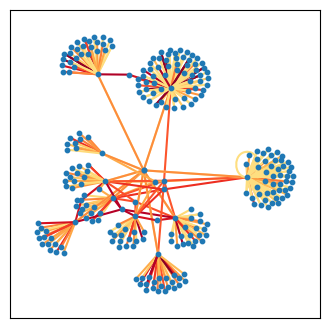

In [ ]:
# Choose nodes for visualization
nodes = data.test_idx.numpy()[:10]
edgelist = []
typelist = []

# Ues NetworkX
G = nx.Graph()
for node in nodes:
    neighbors = data.edge_index[0, (data.edge_index[1] == node)].numpy()
    G.add_node(node)
    for neighbor in neighbors:
        G.add_node(neighbor)
        G.add_edge(neighbor, node)
        edgelist.append((neighbor, node))
        type = data.edge_type[torch.logical_and(data.edge_index[0] == neighbor, data.edge_index[1] == node)].numpy()
        typelist.append(type[0])

# Scale edge type values
scale_min, scale_max = 0.2, 1.0
colorlist = (scale_max - scale_min) / (np.max(typelist) - np.min(typelist)) * (typelist - np.min(typelist)) + scale_min

# Plot
fig, ax = plt.subplots(figsize=(4,4))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=list(G), node_size=10)
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color=colorlist, edge_cmap=plt.cm.YlOrRd,
                        width=1.5, ax=ax, edge_vmin=0, edge_vmax=1)
plt.savefig('10-node-subgraph-1.2.png', dpi=300, bbox_inches='tight')

Augment features:

In [ ]:
augment = "arange" # "arange" or "one-hot"
if augment == "arange":
    data.x = torch.arange(data.num_nodes, dtype=torch.float32)[:, None]
elif augment == "one-hot":
    data.x = torch.eye(data.num_nodes, dtype=torch.float32)
dataset.num_augmented_features = data.x.shape[1]

*b. Random baseline*

In [ ]:
def RandomClassifier(pred_len):
    return torch.randint(0, dataset.num_classes, size=(pred_len,))

def eval_random_accuracy(model, eval_y):
    pred = model(eval_y.shape[0])
    correct = pred.eq(eval_y).sum().item()
    total = eval_y.shape[0]
    return correct / total

def use_random():
    # model
    random_model = RandomClassifier

    # test
    accuracy = eval_random_accuracy(random_model, data.test_y)
    return accuracy

num_runs = 10
accuracies = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    accuracy = use_random()
    accuracies.append(accuracy)
print("Model: Random")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

### Run: 1
### Run: 2
### Run: 3
### Run: 4
### Run: 5
### Run: 6
### Run: 7
### Run: 8
### Run: 9
### Run: 10
Model: Random
Accuracies: [0.1414141414141414, 0.09595959595959595, 0.07575757575757576, 0.10606060606060606, 0.09595959595959595, 0.09090909090909091, 0.08080808080808081, 0.050505050505050504, 0.08585858585858586, 0.10101010101010101]
Mean: 0.09242424242424242
Standard deviation: 0.022135966667485983


*c. Feature baseline*

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, node_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.logits = nn.Linear(node_dim, num_classes)

    def forward(self, x):
        return self.logits(x)

    @torch.no_grad()
    def eval_accuracy(self, eval_x, eval_y):
        pred = self(eval_x).max(dim=1)[1]
        correct = pred.eq(eval_y).sum().item()
        total = eval_x.shape[0]
        return correct / total

def use_mlp(seed):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    mlp_model = MLPClassifier(dataset.num_augmented_features, dataset.num_classes)
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)

    # train
    for epoch in range(100):
        mlp_model.train()
        feature, label = data.x[data.train_idx], data.train_y
        pred = mlp_model(feature)
        loss = F.cross_entropy(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 20 == 0:
            accuracy = mlp_model.eval_accuracy(data.x[data.test_idx], data.test_y)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, accuracy))

    # test
    accuracy = mlp_model.eval_accuracy(data.x[data.test_idx], data.test_y)
    return accuracy

seed_list = [0, 6415, 10492]
num_runs = len(seed_list)
accuracies = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    accuracy = use_mlp(seed=seed_list[run])
    accuracies.append(accuracy)
print("Model: MLP")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

### Run: 1
Epoch: 20	Validation accuracy: 0.3484848484848485
Epoch: 40	Validation accuracy: 0.3484848484848485
Epoch: 60	Validation accuracy: 0.3484848484848485
Epoch: 80	Validation accuracy: 0.08585858585858586
Epoch: 100	Validation accuracy: 0.06565656565656566
### Run: 2
Epoch: 20	Validation accuracy: 0.04040404040404041
Epoch: 40	Validation accuracy: 0.08080808080808081
Epoch: 60	Validation accuracy: 0.3484848484848485
Epoch: 80	Validation accuracy: 0.3484848484848485
Epoch: 100	Validation accuracy: 0.3434343434343434
### Run: 3
Epoch: 20	Validation accuracy: 0.025252525252525252
Epoch: 40	Validation accuracy: 0.050505050505050504
Epoch: 60	Validation accuracy: 0.04040404040404041
Epoch: 80	Validation accuracy: 0.030303030303030304
Epoch: 100	Validation accuracy: 0.3484848484848485
Model: MLP
Accuracies: [0.06565656565656566, 0.3434343434343434, 0.3484848484848485]
Mean: 0.25252525252525254
Standard deviation: 0.1321522013925277


#### 1.2.2 Is bigger = better?

In [ ]:
import torch.nn.init as init
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_gnn_layers, rgcn=pyg_nn.RGCNConv):
        super(GNNClassifier, self).__init__()
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(rgcn(input_dim, hidden_dim, dataset.num_relations, num_bases=30))
        # self.input_embed = nn.Parameter(torch.empty(input_dim, hidden_dim))
        # init.xavier_uniform_(self.input_embed)
        for i in range(num_gnn_layers - 1):
            if i != num_gnn_layers - 2:
                self.gnn_layers.append(rgcn(hidden_dim, hidden_dim, dataset.num_relations, num_bases=30))
            else:
                self.gnn_layers.append(rgcn(hidden_dim, num_classes, dataset.num_relations, num_bases=30))

    def forward(self, edge_index, edge_type):
        # x = self.input_embed
        for i, layer in enumerate(self.gnn_layers):
            if i == 0:
                x = layer(None, edge_index, edge_type)
            else:
                x = layer(x, edge_index, edge_type)
            if i < len(self.gnn_layers) - 1:
                x = F.relu(x)
        return F.log_softmax(x, dim=1)

    @torch.no_grad()
    def eval_accuracy(self, edge_index, edge_type, eval_idx, eval_label):
        pred = self(edge_index, edge_type).max(dim=1)[1]
        correct = pred[eval_idx].eq(eval_label).sum().item()
        total = eval_idx.shape[0]
        return correct / total

def use_gnn(seed, hidden_dim, num_gnn_layers):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = GNNClassifier(input_dim=data.num_nodes,
                              hidden_dim=hidden_dim,
                              num_classes=dataset.num_classes,
                              num_gnn_layers=num_gnn_layers).to("cuda")
    total_params = sum(p.numel() for p in gnn_model.parameters())
    print("total parameters: {}".format(total_params))
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01, weight_decay=5e-4)

    # data
    x, edge_index, edge_type = data.x, data.edge_index.to("cuda"), data.edge_type.to("cuda")
    train_y, train_idx, test_y, test_idx = data.train_y.to("cuda"), data.train_idx.to("cuda"), data.test_y.to("cuda"), data.test_idx.to("cuda")

    # train
    for epoch in tqdm(range(100)):
        gnn_model.train()
        pred = gnn_model(edge_index, edge_type)
        loss = F.nll_loss(pred[train_idx], train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            accuracy = gnn_model.eval_accuracy(edge_index, edge_type, test_idx, test_y)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, accuracy))

    # test
    accuracy = gnn_model.eval_accuracy(edge_index, edge_type, test_idx, test_y)
    return accuracy

Best model:

In [ ]:
seed_list = [0, 42, 14504]
num_runs = len(seed_list)
accuracies = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    accuracy = use_gnn(seed=seed_list[run], hidden_dim=8, num_gnn_layers=2)
    accuracies.append(accuracy)
print("Model: Best model in section 1.1.5")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

### Run: 1
total parameters: 4526355


 10%|█         | 10/100 [00:13<01:47,  1.19s/it]

Epoch: 10	Validation accuracy: 0.6919191919191919


 20%|██        | 20/100 [00:24<01:31,  1.15s/it]

Epoch: 20	Validation accuracy: 0.803030303030303


 30%|███       | 30/100 [00:35<01:20,  1.15s/it]

Epoch: 30	Validation accuracy: 0.8282828282828283


 40%|████      | 40/100 [00:46<01:09,  1.15s/it]

Epoch: 40	Validation accuracy: 0.8535353535353535


 50%|█████     | 50/100 [00:56<00:57,  1.15s/it]

Epoch: 50	Validation accuracy: 0.8535353535353535


 60%|██████    | 60/100 [01:07<00:46,  1.16s/it]

Epoch: 60	Validation accuracy: 0.8535353535353535


 70%|███████   | 70/100 [01:18<00:34,  1.16s/it]

Epoch: 70	Validation accuracy: 0.8737373737373737


 80%|████████  | 80/100 [01:28<00:22,  1.15s/it]

Epoch: 80	Validation accuracy: 0.8737373737373737


 90%|█████████ | 90/100 [01:39<00:11,  1.15s/it]

Epoch: 90	Validation accuracy: 0.8686868686868687


100%|██████████| 100/100 [01:50<00:00,  1.10s/it]

Epoch: 100	Validation accuracy: 0.8636363636363636


### Run: 2
total parameters: 4526355


 10%|█         | 10/100 [00:10<01:43,  1.15s/it]

Epoch: 10	Validation accuracy: 0.6262626262626263


 20%|██        | 20/100 [00:21<01:31,  1.15s/it]

Epoch: 20	Validation accuracy: 0.7929292929292929


 30%|███       | 30/100 [00:31<01:20,  1.14s/it]

Epoch: 30	Validation accuracy: 0.8181818181818182


 40%|████      | 40/100 [00:42<01:08,  1.15s/it]

Epoch: 40	Validation accuracy: 0.8282828282828283


 50%|█████     | 50/100 [00:53<00:57,  1.15s/it]

Epoch: 50	Validation accuracy: 0.8383838383838383


 60%|██████    | 60/100 [01:03<00:45,  1.14s/it]

Epoch: 60	Validation accuracy: 0.8636363636363636


 70%|███████   | 70/100 [01:14<00:34,  1.15s/it]

Epoch: 70	Validation accuracy: 0.8636363636363636


 80%|████████  | 80/100 [01:25<00:23,  1.15s/it]

Epoch: 80	Validation accuracy: 0.8585858585858586


 90%|█████████ | 90/100 [01:36<00:11,  1.14s/it]

Epoch: 90	Validation accuracy: 0.8535353535353535


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

Epoch: 100	Validation accuracy: 0.8484848484848485
### Run: 3


total parameters: 4526355


 10%|█         | 10/100 [00:10<01:42,  1.14s/it]

Epoch: 10	Validation accuracy: 0.7171717171717171


 20%|██        | 20/100 [00:21<01:31,  1.15s/it]

Epoch: 20	Validation accuracy: 0.8333333333333334


 30%|███       | 30/100 [00:31<01:20,  1.15s/it]

Epoch: 30	Validation accuracy: 0.8585858585858586


 40%|████      | 40/100 [00:42<01:09,  1.15s/it]

Epoch: 40	Validation accuracy: 0.8636363636363636


 50%|█████     | 50/100 [00:53<00:57,  1.15s/it]

Epoch: 50	Validation accuracy: 0.8686868686868687


 60%|██████    | 60/100 [01:04<00:45,  1.15s/it]

Epoch: 60	Validation accuracy: 0.8686868686868687


 70%|███████   | 70/100 [01:14<00:34,  1.15s/it]

Epoch: 70	Validation accuracy: 0.8737373737373737


 80%|████████  | 80/100 [01:25<00:22,  1.15s/it]

Epoch: 80	Validation accuracy: 0.8838383838383839


 90%|█████████ | 90/100 [01:36<00:11,  1.14s/it]

Epoch: 90	Validation accuracy: 0.8838383838383839


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

Epoch: 100	Validation accuracy: 0.8787878787878788
Model: Best model in section 1.1.5
Accuracies: [0.8636363636363636, 0.8484848484848485, 0.8787878787878788]
Mean: 0.8636363636363636
Standard deviation: 0.012371160317086747


In [ ]:
import gc
gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing
with torch.no_grad():
    torch.cuda.empty_cache()

Worst model:

In [ ]:
seed_list = [0, 42, 14504]
num_runs = len(seed_list)
accuracies = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    accuracy = use_gnn(seed=seed_list[run], hidden_dim=8, num_gnn_layers=60)
    accuracies.append(accuracy)
print("Model: Worst model in section 1.1.5")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

### Run: 1
total parameters: 5104731


 10%|█         | 10/100 [02:39<25:42, 17.14s/it]

Epoch: 10	Validation accuracy: 0.3333333333333333


 20%|██        | 20/100 [05:18<22:59, 17.25s/it]

Epoch: 20	Validation accuracy: 0.35353535353535354


 30%|███       | 30/100 [07:55<19:53, 17.04s/it]

Epoch: 30	Validation accuracy: 0.3888888888888889


 40%|████      | 40/100 [10:33<17:07, 17.12s/it]

Epoch: 40	Validation accuracy: 0.3888888888888889


 50%|█████     | 50/100 [13:12<14:12, 17.04s/it]

Epoch: 50	Validation accuracy: 0.601010101010101


 60%|██████    | 60/100 [15:51<11:30, 17.26s/it]

Epoch: 60	Validation accuracy: 0.7474747474747475


 70%|███████   | 70/100 [18:30<08:38, 17.27s/it]

Epoch: 70	Validation accuracy: 0.7777777777777778


 80%|████████  | 80/100 [21:10<05:45, 17.26s/it]

Epoch: 80	Validation accuracy: 0.7626262626262627


 90%|█████████ | 90/100 [23:49<02:52, 17.22s/it]

Epoch: 90	Validation accuracy: 0.7929292929292929


100%|██████████| 100/100 [26:28<00:00, 15.89s/it]

Epoch: 100	Validation accuracy: 0.7878787878787878


### Run: 2
total parameters: 5104731


 10%|█         | 10/100 [02:37<25:31, 17.01s/it]

Epoch: 10	Validation accuracy: 0.12121212121212122


 20%|██        | 20/100 [05:15<22:47, 17.09s/it]

Epoch: 20	Validation accuracy: 0.41919191919191917


 30%|███       | 30/100 [07:52<19:53, 17.05s/it]

Epoch: 30	Validation accuracy: 0.702020202020202


 40%|████      | 40/100 [10:30<17:01, 17.03s/it]

Epoch: 40	Validation accuracy: 0.8080808080808081


 50%|█████     | 50/100 [13:08<14:12, 17.06s/it]

Epoch: 50	Validation accuracy: 0.8080808080808081


 60%|██████    | 60/100 [15:46<11:22, 17.07s/it]

Epoch: 60	Validation accuracy: 0.8080808080808081


 70%|███████   | 70/100 [18:24<08:31, 17.06s/it]

Epoch: 70	Validation accuracy: 0.7828282828282829


 80%|████████  | 80/100 [21:04<05:45, 17.29s/it]

Epoch: 80	Validation accuracy: 0.7878787878787878


 90%|█████████ | 90/100 [23:43<02:52, 17.24s/it]

Epoch: 90	Validation accuracy: 0.803030303030303


100%|██████████| 100/100 [26:23<00:00, 15.83s/it]

Epoch: 100	Validation accuracy: 0.803030303030303


### Run: 3
total parameters: 5104731


 10%|█         | 10/100 [02:38<25:50, 17.23s/it]

Epoch: 10	Validation accuracy: 0.6565656565656566


 20%|██        | 20/100 [05:19<23:20, 17.50s/it]

Epoch: 20	Validation accuracy: 0.7929292929292929


 30%|███       | 30/100 [07:59<20:19, 17.43s/it]

Epoch: 30	Validation accuracy: 0.8131313131313131


 40%|████      | 40/100 [10:39<17:10, 17.18s/it]

Epoch: 40	Validation accuracy: 0.797979797979798


 50%|█████     | 50/100 [13:17<14:17, 17.14s/it]

Epoch: 50	Validation accuracy: 0.7575757575757576


 60%|██████    | 60/100 [15:56<11:27, 17.18s/it]

Epoch: 60	Validation accuracy: 0.803030303030303


 70%|███████   | 70/100 [18:36<08:39, 17.32s/it]

Epoch: 70	Validation accuracy: 0.8282828282828283


 80%|████████  | 80/100 [21:15<05:43, 17.17s/it]

Epoch: 80	Validation accuracy: 0.8383838383838383


 90%|█████████ | 90/100 [23:54<02:51, 17.19s/it]

Epoch: 90	Validation accuracy: 0.8333333333333334


100%|██████████| 100/100 [26:31<00:00, 15.92s/it]

Epoch: 100	Validation accuracy: 0.8282828282828283


Model: Worst model in section 1.1.5
Accuracies: [0.7878787878787878, 0.803030303030303, 0.8282828282828283]
Mean: 0.8063973063973063
Standard deviation: 0.016665816391602147


#### 1.2.3 Better GNN

In [ ]:
import torch.nn.init as init
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_gnn_layers, rgcn=pyg_nn.RGCNConv):
        super(GNNClassifier, self).__init__()
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(rgcn(input_dim, hidden_dim, dataset.num_relations, num_bases=20))
        # self.input_embed = nn.Parameter(torch.empty(input_dim, hidden_dim))
        # init.xavier_uniform_(self.input_embed)
        for i in range(num_gnn_layers - 1):
            if i != num_gnn_layers - 2:
                self.gnn_layers.append(rgcn(hidden_dim, hidden_dim, dataset.num_relations, num_bases=20))
            else:
                self.gnn_layers.append(rgcn(hidden_dim, num_classes, dataset.num_relations, num_bases=20))

    def forward(self, edge_index, edge_type):
        # x = self.input_embed
        for i, layer in enumerate(self.gnn_layers):
            if i == 0:
                x = layer(None, edge_index, edge_type)
            else:
                x = layer(x, edge_index, edge_type)
            if i < len(self.gnn_layers) - 1:
                x = F.relu(x)
        return F.log_softmax(x, dim=1)

    @torch.no_grad()
    def eval_accuracy(self, edge_index, edge_type, eval_idx, eval_label):
        pred = self(edge_index, edge_type).max(dim=1)[1]
        correct = pred[eval_idx].eq(eval_label).sum().item()
        total = eval_idx.shape[0]
        return correct / total

def use_gnn(seed, hidden_dim, num_gnn_layers):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = GNNClassifier(input_dim=data.num_nodes,
                              hidden_dim=hidden_dim,
                              num_classes=dataset.num_classes,
                              num_gnn_layers=num_gnn_layers).to("cuda")
    total_params = sum(p.numel() for p in gnn_model.parameters())
    print("total parameters: {}".format(total_params))
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01, weight_decay=5e-4)

    # data
    x, edge_index, edge_type = data.x, data.edge_index.to("cuda"), data.edge_type.to("cuda")
    train_y, train_idx, test_y, test_idx = data.train_y.to("cuda"), data.train_idx.to("cuda"), data.test_y.to("cuda"), data.test_idx.to("cuda")

    # train
    for epoch in tqdm(range(100)):
        gnn_model.train()
        pred = gnn_model(edge_index, edge_type)
        loss = F.nll_loss(pred[train_idx], train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            accuracy = gnn_model.eval_accuracy(edge_index, edge_type, test_idx, test_y)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, accuracy))

    # test
    accuracy = gnn_model.eval_accuracy(edge_index, edge_type, test_idx, test_y)
    return accuracy

In [ ]:
import gc
gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
seed_list = [14504]
num_runs = len(seed_list)
accuracies = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    accuracy = use_gnn(seed=seed_list[run], hidden_dim=16, num_gnn_layers=2)
    accuracies.append(accuracy)
print("Model: Best model in section 1.1.5")
print("Accuracies: {}".format(accuracies))
print("Mean: {}".format(np.mean(accuracies)))
print("Standard deviation: {}".format(np.std(accuracies)))

### Run: 1
total parameters: 6121499


 10%|█         | 10/100 [00:16<02:40,  1.78s/it]

Epoch: 10	Validation accuracy: 0.7171717171717171


 20%|██        | 20/100 [00:33<02:22,  1.78s/it]

Epoch: 20	Validation accuracy: 0.8232323232323232


 30%|███       | 30/100 [00:49<02:04,  1.78s/it]

Epoch: 30	Validation accuracy: 0.8686868686868687


 40%|████      | 40/100 [01:06<01:46,  1.78s/it]

Epoch: 40	Validation accuracy: 0.8636363636363636


 50%|█████     | 50/100 [01:23<01:29,  1.79s/it]

Epoch: 50	Validation accuracy: 0.8787878787878788


 60%|██████    | 60/100 [01:39<01:11,  1.79s/it]

Epoch: 60	Validation accuracy: 0.8787878787878788


 70%|███████   | 70/100 [01:56<00:53,  1.78s/it]

Epoch: 70	Validation accuracy: 0.8737373737373737


 80%|████████  | 80/100 [02:13<00:35,  1.78s/it]

Epoch: 80	Validation accuracy: 0.8737373737373737


 90%|█████████ | 90/100 [02:29<00:17,  1.78s/it]

Epoch: 90	Validation accuracy: 0.8787878787878788


100%|██████████| 100/100 [02:46<00:00,  1.67s/it]

Epoch: 100	Validation accuracy: 0.8737373737373737


Model: Best model in section 1.1.5
Accuracies: [0.8737373737373737]
Mean: 0.8737373737373737
Standard deviation: 0.0
